Random forests are very elegant and very hard to mess up

In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

In [7]:
df = pd.read_csv('titanic_datasets/train.csv')
tst_df = pd.read_csv('titanic_datasets/test.csv')
modes = df.mode().iloc[0]
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Basic data preprocessing

In [8]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

proc_data(df)
proc_data(tst_df)

In [9]:
#Convert Sex and Embarked fields to categorical variables 
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
dep="Survived"

In [10]:
df.Sex.head()
#Pandas has made a list of all unique values 

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [11]:
#Pandas turned them into numbers. (No need to create dummy variables)
df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

### Binary Splits (a tree is an ensemble of binary splits. A random forest is an ensemble of trees)

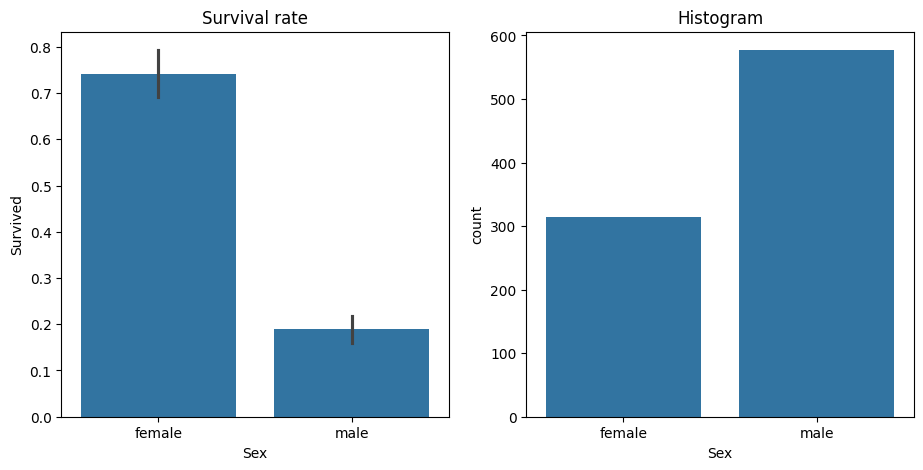

In [14]:
import seaborn as sns

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

In [15]:
#Simple "model" which im says all females survive, no males do
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [16]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [17]:
preds = val_xs.Sex==0 #predict they'll survive if Sex=0 (female)

In [18]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds) #21.5 % error: pretty good model

0.21524663677130046

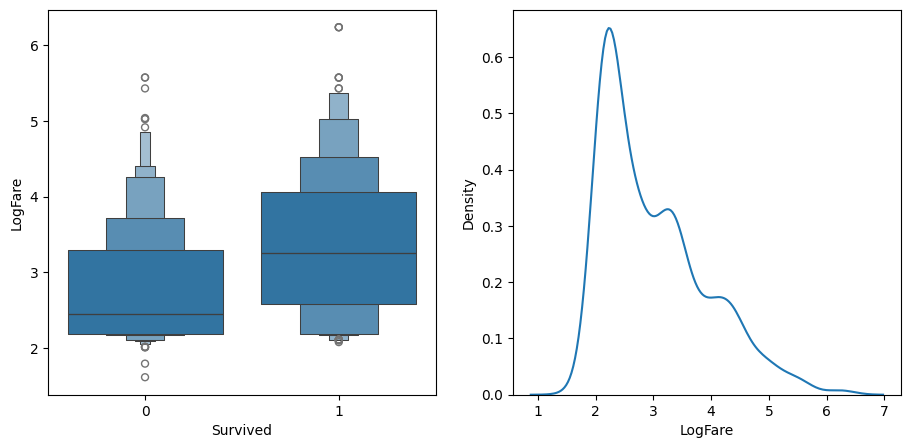

In [19]:
#Another model where we split on a continuous column (fare)
df_fare = trn_df[trn_df.LogFare>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1]);

Median fare for those who survived is higher
* avg: 2.5 for survived=0, and 3.2 for survived=1

In [20]:
preds = val_xs.LogFare>2.7

In [21]:
mean_absolute_error(val_y, preds) #much worse.

0.336322869955157

Create a quick interactive tool

In [22]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot #std dev: how similar are all the things in a group. 
#Add the std dev of the two groups of the dep. variables
#std dev multiply by total (how many things are in that group)

In [23]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y) 
#score is all the things on the left side + all the thiings on the right side, and take the avg of that.

In [24]:
score(trn_xs["Sex"], trn_y, 0.5) #Sex is still a better split

0.40787530982063946

In [25]:
score(trn_xs["LogFare"], trn_y, 2.7)

0.47180873952099694

In [26]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

In [27]:
interact(nm=cats, split=2)(iscore);

interactive(children=(Dropdown(description='nm', options=('Sex', 'Embarked'), value='Sex'), IntSlider(value=2,…

Try to find an automatic way to do all these

In [28]:
#Best split points for age
nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  , 23.  , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  ,
       55.5 , 56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

In [29]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()] #6 seems to be the optimal cutoff according to our training set.

6.0

In [30]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "Age")

(6.0, 0.478316717508991)

In [31]:
#Try all the columns
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (0, 0.40787530982063946),
 'Embarked': (0, 0.47883342573147836),
 'Age': (6.0, 0.478316717508991),
 'SibSp': (4, 0.4783740258817434),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736597),
 'Pclass': (2, 0.46048261885806596)}

Lowest score is sex. 
* This is how you calculate the best single binary split model we can find.
* Next we learn to do this iteratively to create a decision trees, then a random forest